# Сессия_1

### ЗАГРУЗКА ДАННЫХ

*Загружаю данные и все необходимые библиотеки*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams ['figure.figsize']=(8,4)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier , plot_importance
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn import datasets
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from  sklearn import decomposition
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv('data.csv')
df.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


### ПРЕДВАРИТЕЛЬНОЕ ИЗУЧЕНИЕ

*Посмотим на целевой признак:*

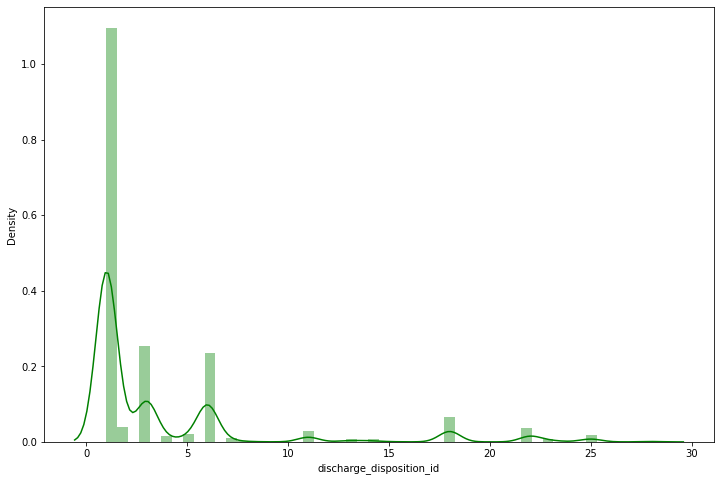

In [3]:
plt.figure(figsize=(12,8))
sns.distplot(df['discharge_disposition_id'], color='g');

*Из гистограммы видно, что больше всего людей имеют 9 диагнозов*

*Посмотрим на распределение признаков*

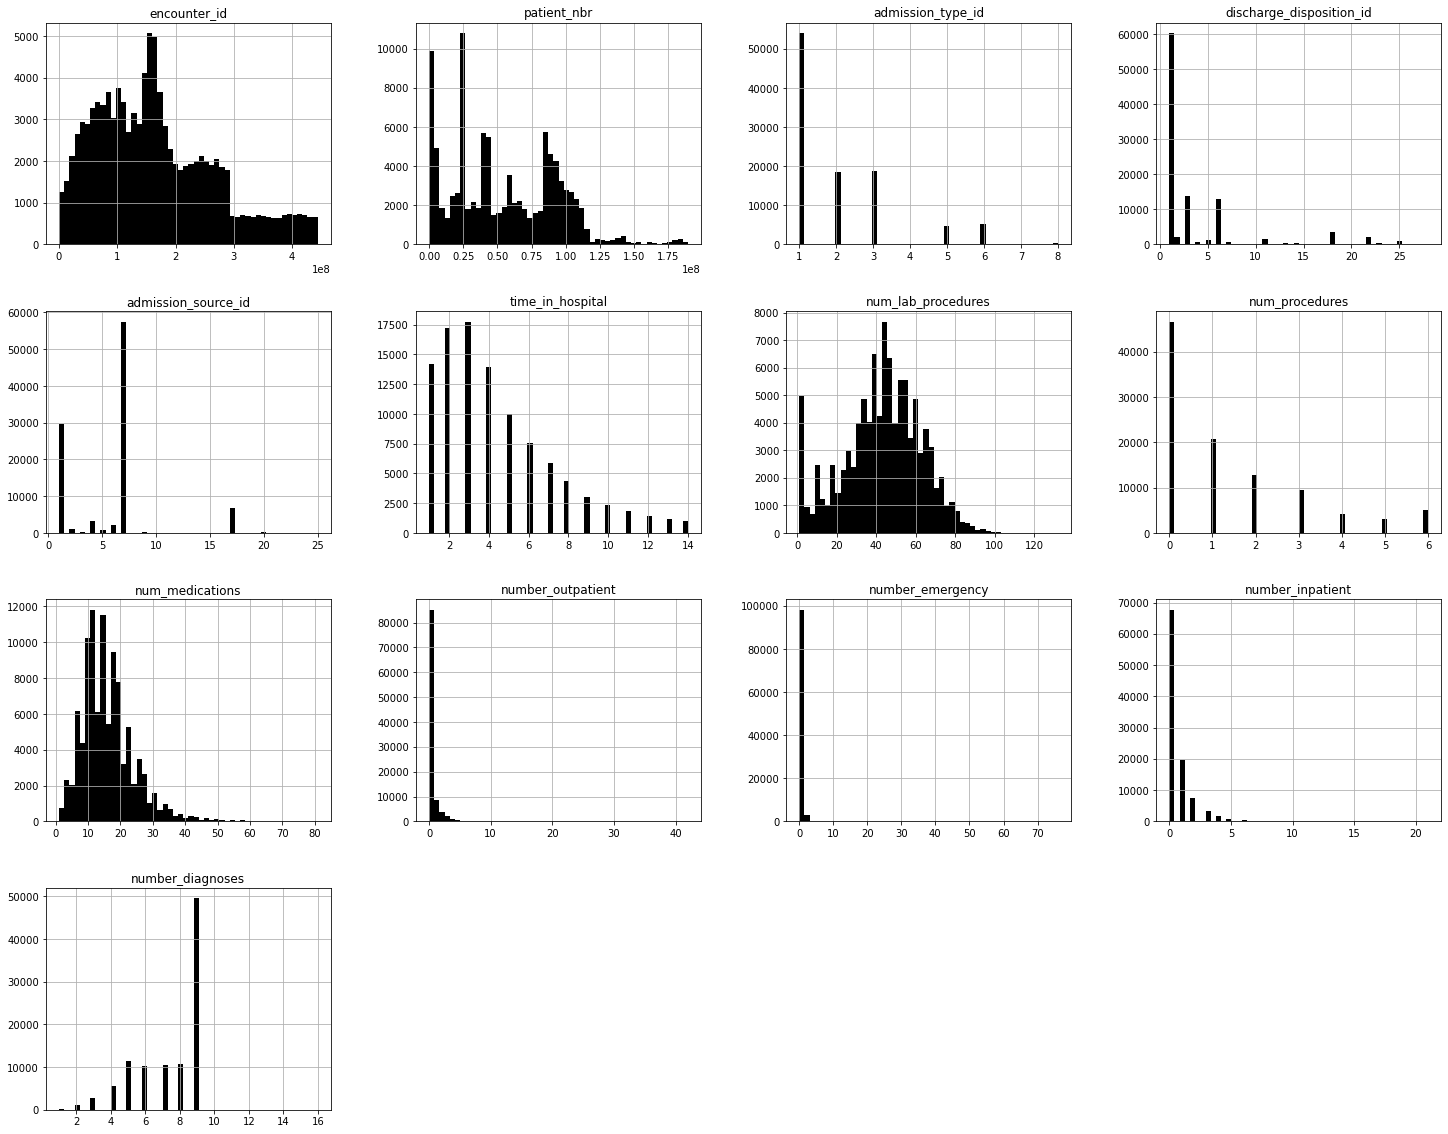

In [4]:
df.hist(figsize=(25,20),color="k",bins=50);

*Большинство наблюдений располагаются от большего значения к меньшем, и имеют ассимитрично левосторонний сдвиг, для обучения это плохо, но рапределение может измениться после предобработки данных, поэтому оставим все признаки для предобработки*

### ЧИСТКА/ ОБРАБОТКА НЕЗНАЧАЩИХ СИМВОЛОВ В ДАННЫХ

*Для начала избавимся от признаков, у которых больше 80% значений повторяются*

In [5]:
row=len(df.index)
info=[]
for col in df.columns:
    count=df[col].value_counts(dropna=True)
    solf=(count/row).iloc[0]
    if solf>0.8:
        del df[col]
        print(f'{col}')

weight
number_outpatient
number_emergency
max_glu_serum
A1Cresult
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone


*Заменим признаки где присутствует вопросительный знак и т.п на NaN, что бы потом можно было его заменить на другое значение*

In [6]:
for col in df.columns:
    df[col]= df[col].mask(df[col] == "?")

In [7]:
for col in df.columns:
    df[col]= df[col].mask(df[col] == "Up")

In [8]:
for col in df.columns:
    df[col]= df[col].mask(df[col] == "Steady")

*Переведем номинативные признаки в числа*

In [9]:
lbl=LabelEncoder()
non_nomic=df.select_dtypes(exclude=[np.number])
non_momic_cols=non_nomic.columns.values
for col in non_momic_cols:
    df[col]=lbl.fit_transform(df[col].astype(str))

*Избавимся от пробелов в значениях выборки*

In [10]:
for column in df.columns:
    if df[column].dtype == object:
        df[column] = df[column].map(str.strip)

In [11]:
cdf=df.drop('readmitted',axis=1)

### ОБРАБОТКА ПУСТЫХ ЗНАЧЕНИЙ

*Выведим на экран количество пропущенных значений*

In [12]:
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
dtype: int64

*Заменим пропущенные значения в признаке 'readmitted', значением 'Yes'*

In [13]:
df['readmitted'].fillna('Yes', inplace=True)

In [14]:
df['insulin'].fillna('Yes', inplace=True)

*Заменим пропущенные значения номинативных признаков, модой числа*

In [15]:
numic=df.select_dtypes(exclude=[np.number])
nomic_cols=numic.columns.values
for col in nomic_cols:
    missing=df[col].isnull()
    df_missing=np.sum(missing)
    if df_missing>0:
        print('{}'.format(col))
        df['{}_missing'.format(col)]=missing
        
        df[col]=df[col].dropna()

# Сессия_2

### ОЦЕНКА ВЛИЯНИЯ ПЕРЕМЕННЫХ НА ЦЕЛЕВУЮ ПЕРЕМЕННУЮ

*Помотрим на распределение признаков без целевой переменной:*

In [16]:
cdf=df.drop('readmitted', axis=1)

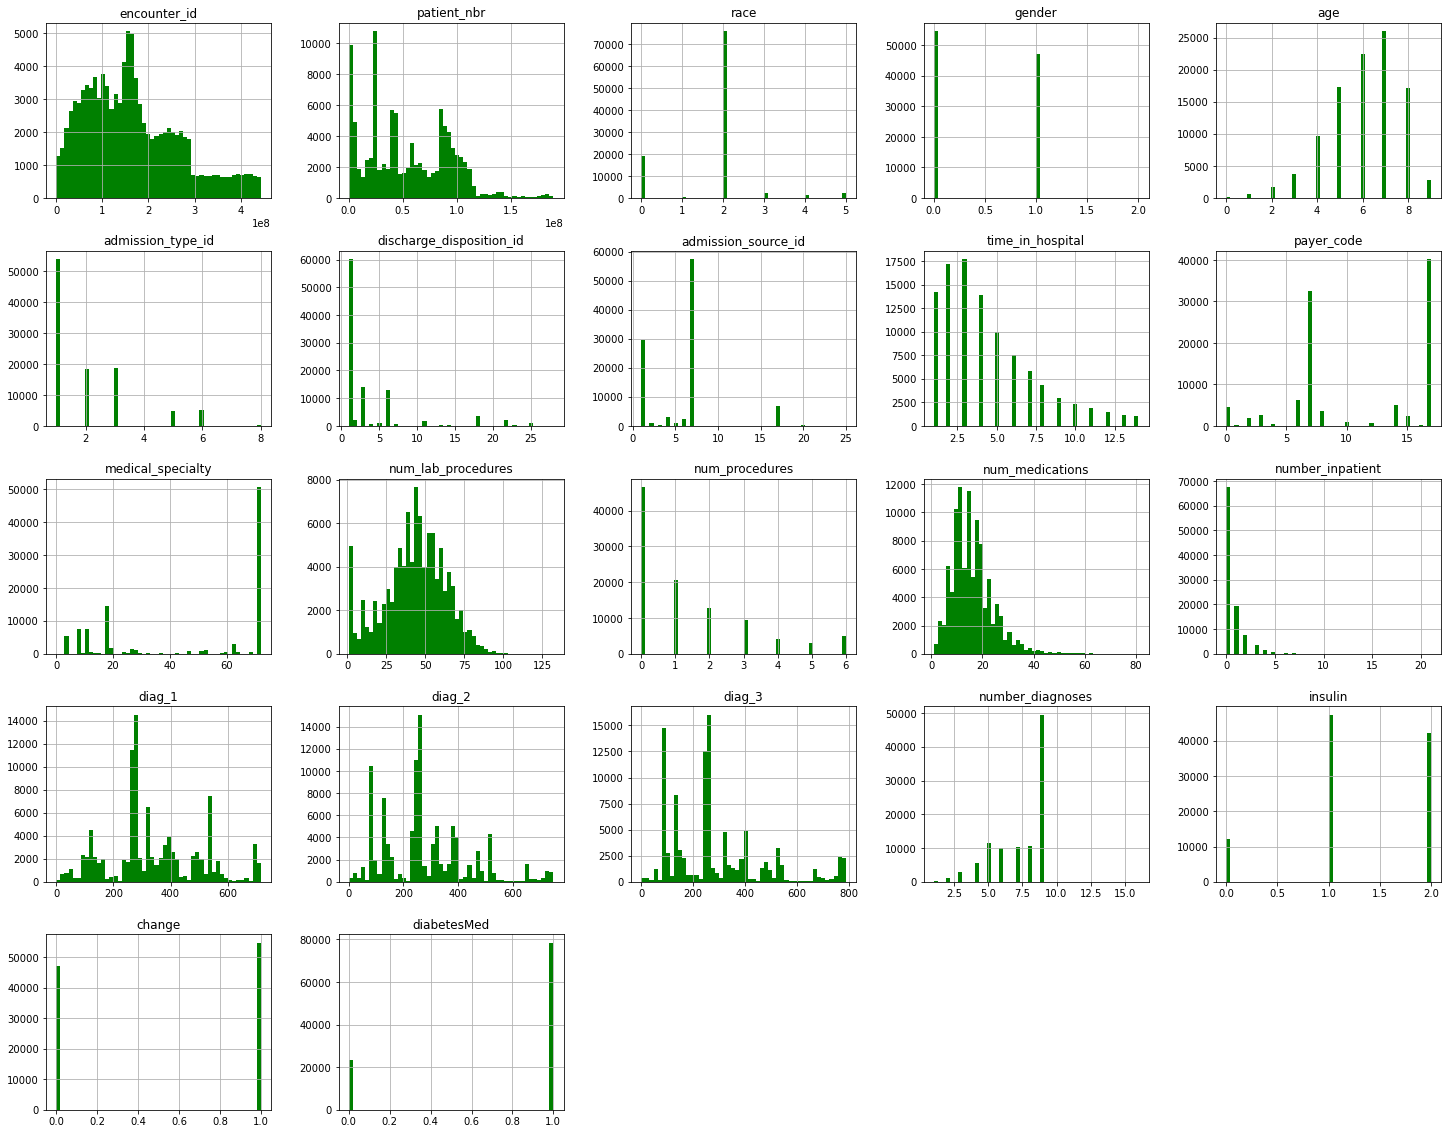

In [17]:
cdf.hist(figsize=(25,20),color="g",bins=50);

*Теперь с целевой переменной*

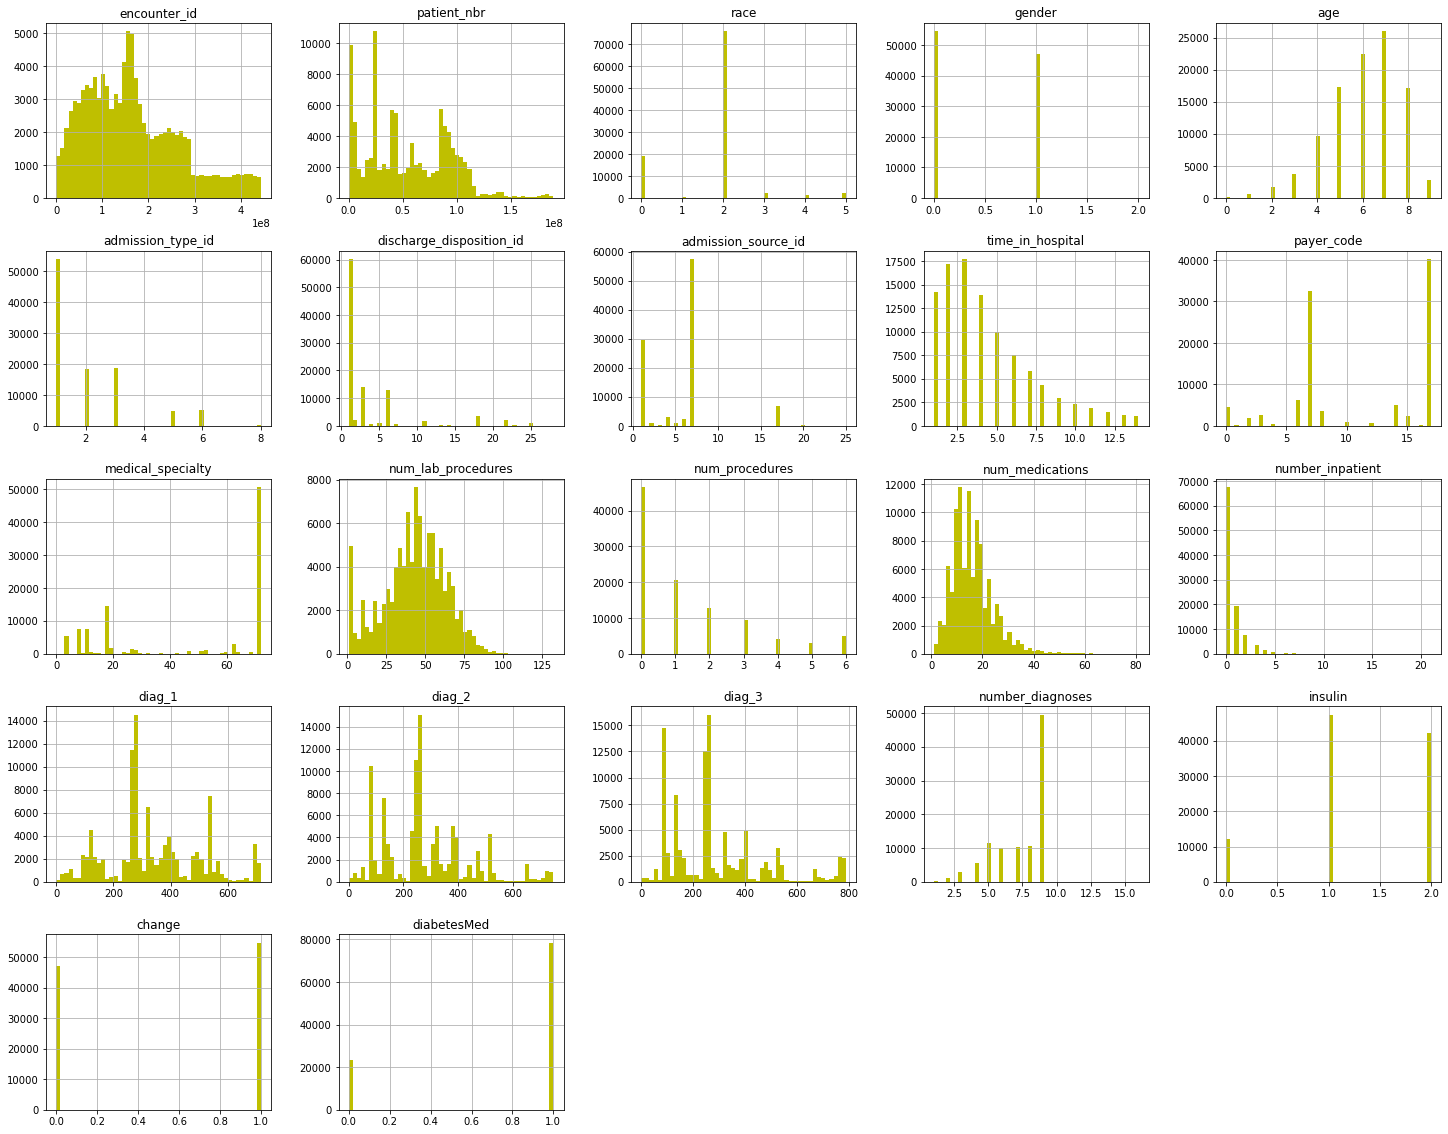

In [18]:
cdf.hist(figsize=(25,20),color="y",bins=50);

*На графике видно, что большинство признаков имеют симметричное распределение(число случаев наблюдений с различной величиной признака располагаются от меньшего значения к большему), это доказывает то, что распределение атрибутов соответствует норме*

### ВЫЯВЛЕНИЕ КОРРЕЛЯЦИЙ МЕЖДУ ПЕРЕМЕННЫМИ

*Выведем признаки корреляция*

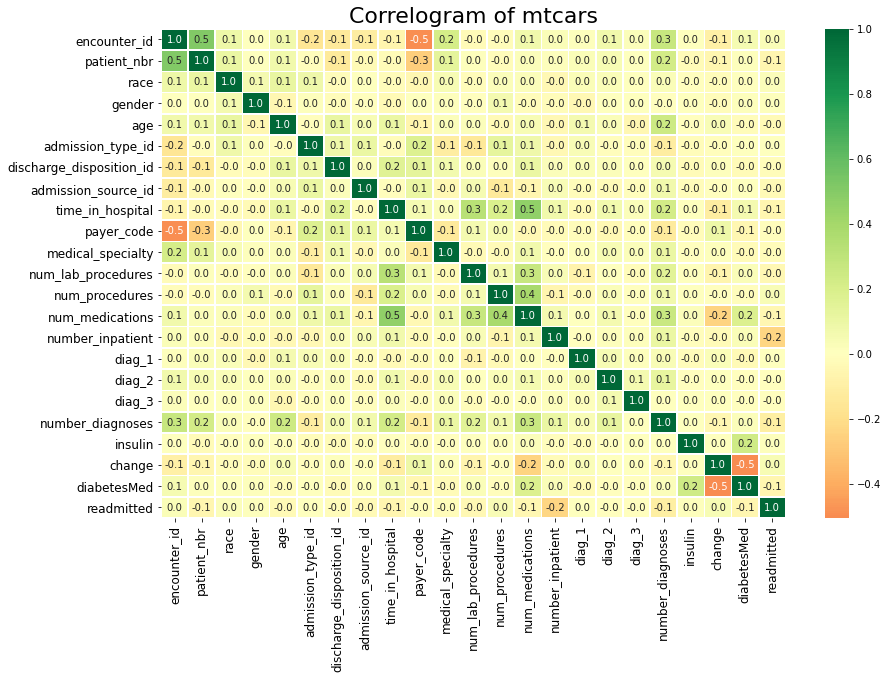

In [19]:
plt.figure(figsize=(14,9))
plt.title('Correlogram of mtcars', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr()
.columns, cmap='RdYlGn', center=0, annot=True,fmt=".1f",linewidths=.7,)
plt.show()

### ВИЗУАЛИЗАЦИЯ ЗАВИСИМОСТЕЙ, ВЫЯВЛЯЮЩИХ ОСОБЕННОСТИ ДАННЫХ

*Посмотрим на попарную зависимость между признаками:*

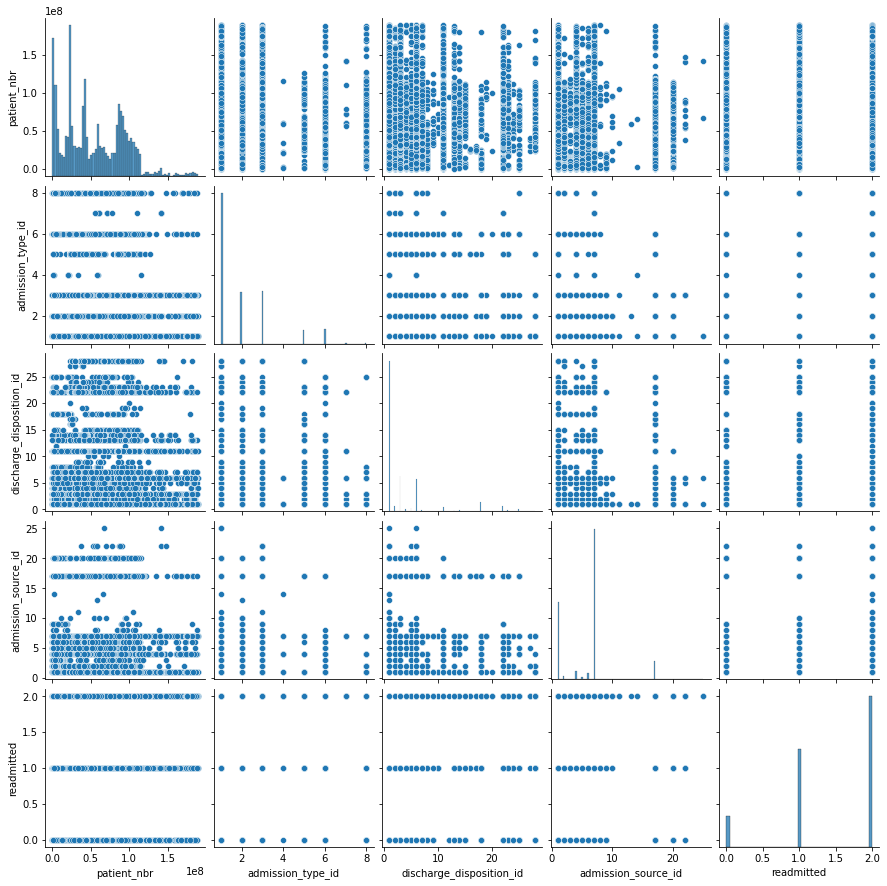

In [20]:
cdf=df[['patient_nbr', 'admission_type_id','discharge_disposition_id','admission_source_id','readmitted']]
sns.pairplot(cdf);

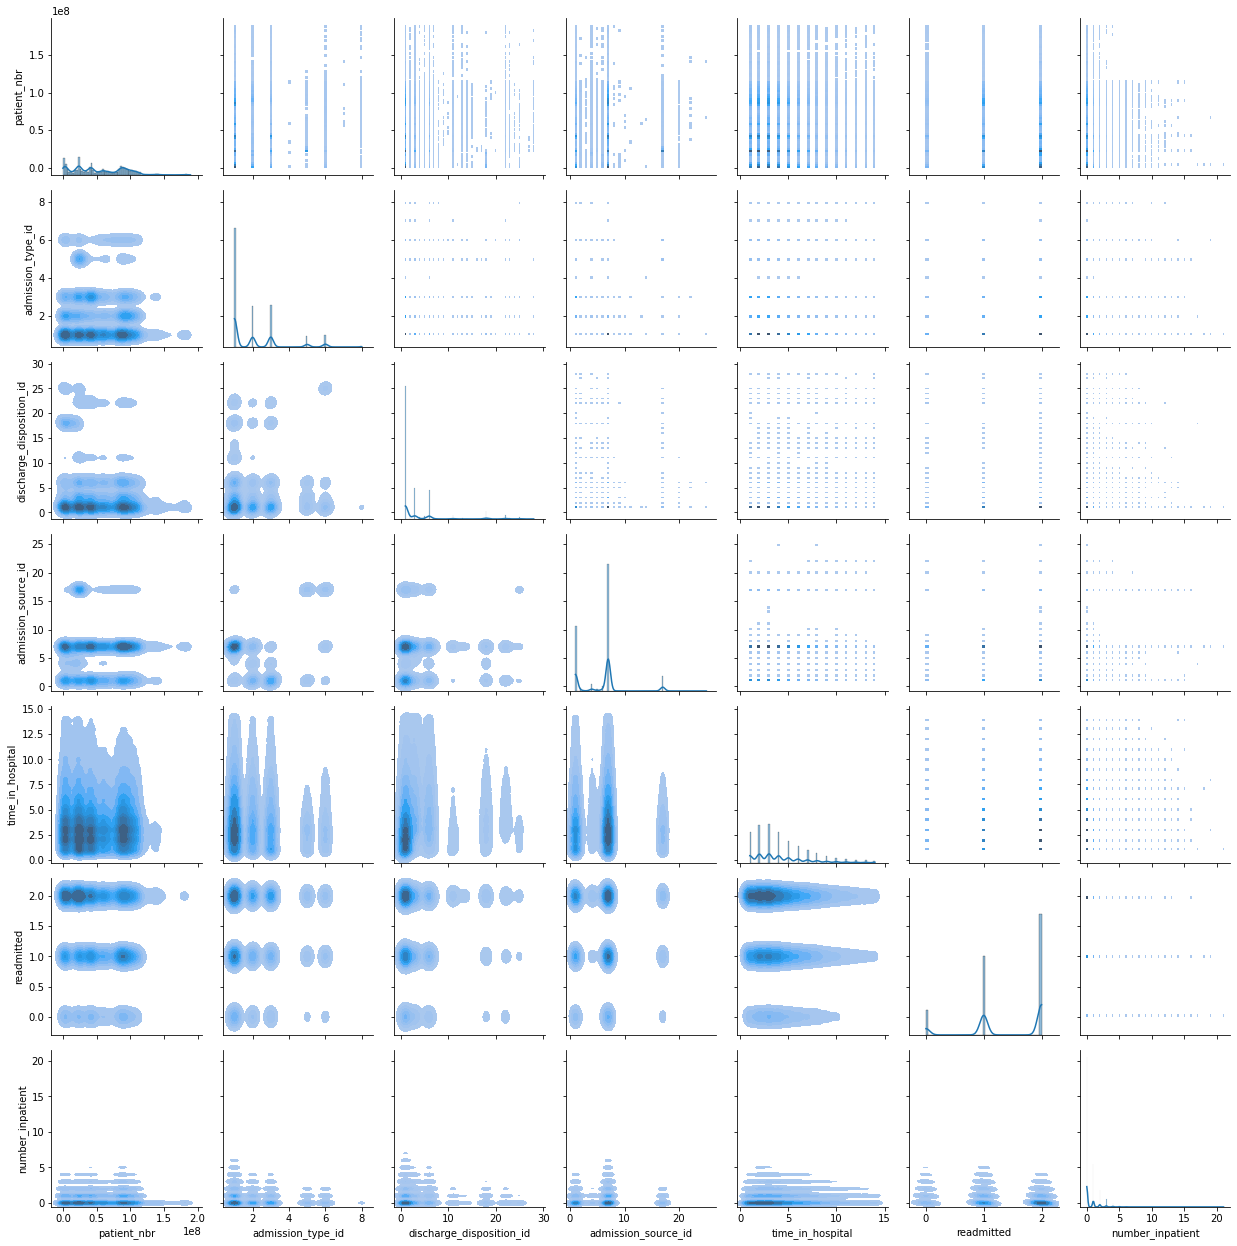

In [23]:
dfc=df[['patient_nbr', 'admission_type_id','discharge_disposition_id','admission_source_id','time_in_hospital','readmitted', 'number_inpatient']]
g = sns.PairGrid(dfc)
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True); 

*Видно, что в выборке нет выбросов, а также , большинство признаков не имеют схожести, это озночает, что такие признаки можно оставить для дальнейшего обучения*

# Сессия_3

### ОТБОР ПРИЗНАКОВ 

*Удалю признаки, имеющие корреляцию больше 0.2*

In [24]:
for col in df.columns:
    x=np.array(df['readmitted'])
    y=np.array(df[col])
    coef=np.corrcoef(x,y)[0,1]
    if coef>0.3 and coef<0.9:
        print(f'{col}-{coef}')
        del df[col]

### ВЫБОР И ПОСТРОЕНИЕ НОВЫХ ПЕРЕМЕННЫХ; ТЕСТИРОВАНИЕ ЗНАЧИМОСТИ ВЫБРАННЫХ  ПЕРЕМЕННЫХ 

*Создадим новую преременную, в которой будет содержать информация о переменных diag_1, diag_2 и diag_3, и поэтому можно удалить все три атрибута, это уменьшит размер выборки*

In [25]:
df['diag_1']=df['diag_1'].apply(lambda x:'1' if x<28 else '2'  if x<55 else '3')
df['diag_2']=df['diag_2'].apply(lambda x:'1' if x<28 else '2'  if x<55 else '3')
df['diag_3']=df['diag_3'].apply(lambda x:'1' if x<28 else '2'  if x<55 else '3')

In [26]:
df['diag']=df['diag_1']=df['diag_2']=df['diag_3']

In [27]:
del df['diag_1']
del df['diag_2']
del df['diag_3']

*Также создадим переменную обозначающую во сколько лет повторно допущена болезнь, значения возьмем из целевого признака, тем самым количесиво строк уменьшится, что соответственно увеличить точность прогноза*

In [28]:
df['age_readmitted']=df['readmitted'].apply(lambda x:2 if x==2 else 3)

In [29]:
df['readmitted']=df['readmitted'].apply(lambda x:1 if x==1 else 0)

*Число 2 в новой выборке означает , что поциенту было меньше 30 лет во время повторного заболевания, а число 3, больше 30 лет*

### АРГУМЕНТИРОВАННЫЙ ВЫБОР АЛГОРИТМА КЛАСТЕРИЗАЦИИ 

*Применяем алгоритм principal component analysis*

In [30]:
x = df.drop('readmitted', 1)
y = df['readmitted']

In [31]:
pca = decomposition.PCA(n_components=16)

In [32]:
X_pca=pca.fit_transform(x)

In [33]:
print("Количество признаков после обработки PCA: {0}".format(X_pca.shape[1]))

Количество признаков после обработки PCA: 16


In [34]:
print(format(sum(pca.explained_variance_ratio_)))

0.9999999999999982


In [35]:
print("Точность после обработки PCA:{0}".format(silhouette_score(X_pca,y)))

Точность после обработки PCA:-0.00924418941230897


*Обучаеяем модель с помощью алгоритма k-means*

In [36]:
mean=KMeans(n_clusters=4, random_state=101)

In [37]:
y_pred=mean.fit_transform(x)

In [38]:
print("Количество признаков после обработки k_means: {0}".format(y_pred.shape[1]))

Количество признаков после обработки k_means: 4


In [39]:
print("Точность после обработки k_means:{0}".format(silhouette_score(y_pred,y)))

Точность после обработки k_means:-0.010714281698598773


*Используем кластеризатор t-SNE*

In [40]:
tsne = TSNE(learning_rate=50)

In [41]:
y_pred=tsne.fit_transform(x)

In [42]:
print("Количество признаков после обработки t-SNE: {0}".format(y_pred.shape[1]))

Количество признаков после обработки t-SNE: 2


In [43]:
print("Точность после обработки t-SNE:{0}".format(silhouette_score(y_pred,y)))

Точность после обработки t-SNE:-0.005254159681499004


*Лучше всего обучил модель алгоритм 'k-means'*

# Сессия_4

### РАЗБИЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТИРУЮЩУЮ ВЫБОРКИ

*Нормализуем данные для хорошего прогноза классификатора:*

In [44]:
scal=StandardScaler()

In [45]:
df_scal=scal.fit_transform(df.drop('readmitted', axis=1))

*Разделяем выборку на две части:*

In [46]:
x=df_scal.copy()

In [47]:
y=df['readmitted']

In [48]:
x_train, x_test ,y_train, y_test=train_test_split(x,y,test_size=0.2,random_state=500)

### АРГУМЕНТИРОВАННЫЙ ВЫБОР МОДЕЛИ КЛАССИФИКАЦИИ

*Обучаем модель с помощью алгоритма 'Дерево решений'*

In [49]:
clf = DecisionTreeClassifier(random_state=1)

In [50]:
clf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=1)

In [51]:
y_pred=clf.predict(x_test)

In [52]:
clf.score(x_test, y_test)

0.8428318757983688

In [53]:
y_pred[:10]

array([1, 0, 0, 0, 1, 0, 1, 0, 0, 0], dtype=int64)

In [54]:
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

In [55]:
accuracy_score(y_test, y_pred)

0.8428318757983688

*Настрою гиперпараметры, что бы точность была ещё больше*

In [56]:
сlf=DecisionTreeClassifier(random_state=1)

In [57]:
params={"max_depth":np.arange(1,7,1),"min_samples_leaf":range(1,6,1)}

In [58]:
grid=GridSearchCV(clf, params, cv=5, n_jobs= -1)

In [59]:
%%timeit
grid.fit(x_train, y_train)

4.27 s ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
grid.best_params_

{'max_depth': 6, 'min_samples_leaf': 5}

In [61]:
best_clf = grid.best_estimator_

In [62]:
y_pred = best_clf.predict(x_test)

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     13245
           1       0.77      0.98      0.86      7109

    accuracy                           0.89     20354
   macro avg       0.88      0.91      0.88     20354
weighted avg       0.91      0.89      0.89     20354



In [64]:
grid.best_score_

0.8889107636115273

*Обучение с помощью ансамблевого алгоритма AdaBoost:*

In [65]:
ada=AdaBoostClassifier(random_state=120, n_estimators=20, learning_rate=0.19)

In [66]:
ada.fit(x_train, y_train)

AdaBoostClassifier(learning_rate=0.19, n_estimators=20, random_state=120)

In [67]:
y_pred=ada.predict(x_test)

In [68]:
ada.score(x_test, y_test)

0.8878353149258131

*Обучение с помощью алгоритма lightgbm:*

In [69]:
lgbm = LGBMClassifier(n_estimators=14,random_state=100,learning_rate=0.19 ,max_depth=5, colsample_bytree=0.82,scale_pos_weight=1,seed=11)

In [70]:
lgbm.fit(x_train, y_train)

[LightGBM] [Warning] seed is set=11, random_state=100 will be ignored. Current value: seed=11
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(colsample_bytree=0.82, learning_rate=0.19, max_depth=5,
               n_estimators=14, random_state=100, scale_pos_weight=1, seed=11)

In [71]:
y_pred= lgbm.predict(x_test)

In [72]:
lgbm.score(x_test ,y_test)

0.8899970521764764

*Обучение с помощью алгоритма XGboost:*

In [73]:
xgboost=XGBClassifier(random_state=110,n_estmats=22, learning_rate=0.19,min_child_weight=1,gamma=0,subsample=0.9,colsample_bytree=0.8,nthread=4,scale_pos_weight=1,seed=27)

In [74]:
xgboost.fit(x_train, y_train)

[00:00:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estmats } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:00:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.19, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_estmats=22, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=110, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [75]:
y_pred=xgboost.predict(x_test)

In [76]:
xgboost.score(x_test, y_test)

0.8909796600176869

*Построение roc и auc кривых:*

In [77]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='-.')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [78]:
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.4f' % auc)

AUC: 0.9118


In [79]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

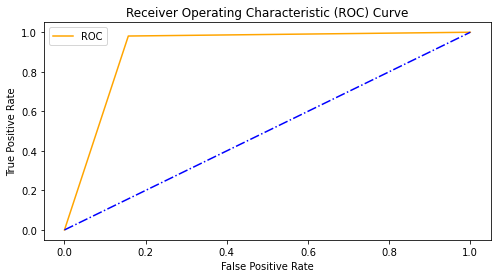

In [80]:
plot_roc_curve(fpr, tpr)

*Лучшим классификатором оказался алгоритм XGboost*